# **Importing Libraries and Dependencies**

In [5]:
# Importing Libraries

try:
    # --- Data Handling and Numerical Operations ---
    import pandas as pd
    import numpy as np
    from datetime import datetime

    # --- Financial Data Acquisition ---
    import yfinance as yf

    # --- Data Visualization ---
    import matplotlib.pyplot as plt
    import seaborn as sns

    # --- Data Preprocessing and Modeling ---
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    import xgboost as xgb

    # --- Model Evaluation Metrics ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # --- Display enhancements for Colab ---
    from IPython.display import display, Markdown

    # --- Ignore harmless warnings ---
    import warnings
    warnings.filterwarnings('ignore')

except ImportError as e:
    print(f"A required library is not installed. Please install it. Error: {e}")
    # In Colab, you would run:
    # !pip install pandas numpy yfinance matplotlib seaborn scikit-learn xgboost
    exit()

# Set plot style for professional aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('talk', font_scale=1.1)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['axes.edgecolor'] = '#222222'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Libraries imported successfully!")

Libraries imported successfully!


# **Data Download and Preprocessing**

In [6]:
# Data Download and Preprocessing

def download_stock_data(ticker, start_date, end_date):
    """
    Downloads historical stock data from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'RELIANCE.NS').
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame containing the stock data, or None if download fails.
    """
    print(f"\nDownloading data for {ticker} from {start_date} to {end_date}...")
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if data.empty:
            print(f"No data found for ticker {ticker}. Please check the symbol and date range.")
            return None
        print("Data downloaded successfully.")
        return data
    except Exception as e:
        print(f"An error occurred while downloading data for {ticker}: {e}")
        return None

def preprocess_and_engineer_features(df):
    """
    Handles missing values and engineers relevant features.

    Args:
        df (pd.DataFrame): Raw stock data.

    Returns:
        pd.DataFrame: Feature-engineered DataFrame with no missing values.
    """
    print("\nStarting data preprocessing and feature engineering...")

    # --- Handle Missing Values ---
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # --- Financial Feature Engineering ---
    df['Returns'] = df['Close'].pct_change()

    # Lag Features (past closing prices)
    lags = [1, 5, 14, 21, 50, 100, 200]
    for lag in lags:
        df[f'lag_{lag}'] = df['Close'].shift(lag)

    # Rolling Mean & Std Features
    rolling_windows = [20, 50]
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
        if window == 20:
            df[f'rolling_std_{window}'] = df['Close'].rolling(window=window).std()

    # --- Time-Based Feature Engineering ---
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    # Remove rows with NaNs due to lag/rolling computations
    df.dropna(inplace=True)

    print("Feature engineering complete.")
    return df



# **Exploratory Data Analysis**

In [ ]:
# EXPLORATORY DATA ANALYSIS (EDA)

def perform_eda(df, ticker):
    """
    Generates and displays professional plots for EDA.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame.
        ticker (str): Stock ticker.
    """
    print("\nPerforming Exploratory Data Analysis (EDA)...")

    # --- Calculate SMAs and EMAs ---
    smas = [7, 14, 21, 50, 100, 200]
    emas = [14, 21, 50, 100, 200]
    for ma in smas:
        df[f'SMA_{ma}'] = df['Close'].rolling(window=ma).mean()
    for ma in emas:
        df[f'EMA_{ma}'] = df['Close'].ewm(span=ma, adjust=False).mean()

    # --- Plotting SMAs with Professional Touch ---
    for ma in smas:
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df['Close'], label='Close Price', color='#1565c0', linewidth=2)
        plt.plot(df.index, df[f'SMA_{ma}'], label=f'{ma}-Day SMA', color='#ffa726', linestyle='--', linewidth=2)
        plt.title(f'{ticker} — {ma}-Day Simple Moving Average (SMA) vs. Close Price', weight='bold')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(frameon=True, fancybox=True)
        plt.tight_layout()
        plt.show()

    # --- Plotting EMAs with Professional Touch ---
    for ma in emas:
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df['Close'], label='Close Price', color='#1565c0', linewidth=2)
        plt.plot(df.index, df[f'EMA_{ma}'], label=f'{ma}-Day EMA', color='#8e24aa', linestyle='-.', linewidth=2)
        plt.title(f'{ticker} — {ma}-Day Exponential Moving Average (EMA) vs. Close Price', weight='bold')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(frameon=True, fancybox=True)
        plt.tight_layout()
        plt.show()

    # --- Plotting Crossovers ---
    crossover_pairs = [('SMA', 21, 50), ('SMA', 100, 200), ('EMA', 21, 50), ('EMA', 100, 200)]
    for ma_type, short_window, long_window in crossover_pairs:
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df['Close'], label='Close Price', color='#757575', alpha=0.4, linewidth=1.5)
        plt.plot(df.index, df[f'{ma_type}_{short_window}'], label=f'{short_window}-Day {ma_type}', color='#ffa726', linewidth=2)
        plt.plot(df.index, df[f'{ma_type}_{long_window}'], label=f'{long_window}-Day {ma_type}', color='#8e24aa', linewidth=2)
        plt.title(f'{ticker} — {short_window}-Day vs. {long_window}-Day {ma_type} Crossover', weight='bold')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(frameon=True, fancybox=True)
        plt.tight_layout()
        plt.show()

    print("EDA plots generated.")

# **Machine Learning Model Training and Forecasting **

In [7]:

# MACHINE LEARNING MODEL TRAINING AND FORECASTING


def train_and_evaluate_models(df):
    """
    Splits data, trains ML models, and evaluates their performance.

    Args:
        df (pd.DataFrame): Feature-engineered DataFrame.

    Returns:
        dict: Trained models and scaler.
        pd.DataFrame: Model performance metrics.
    """
    print("\nStarting Machine Learning model training...")

    # --- Prepare Data for Modeling ---
    features = [col for col in df.columns if col not in ['Close', 'Adj Close', 'Returns']]
    X = df[features]
    y = df['Close']

    # Train-test split (90% training, 10% testing, no shuffling for time series)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

    # --- Standardization ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Model Initialization ---
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    # --- Train and Evaluate ---
    results = {}
    metrics_summary = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R-Squared'])

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results[name] = model
        metrics_summary.loc[name] = [mae, mse, rmse, r2]

        print(f"{name} Metrics: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2%}")

    print("\nModel training and evaluation complete.")
    results['scaler'] = scaler
    results['X_test'] = X_test  # For forecasting

    return results, metrics_summary

def forecast_tomorrow(models_dict, latest_data):
    """
    Forecasts the next day's stock price using the best-performing model.

    Args:
        models_dict (dict): Contains trained models and metrics.
        latest_data (pd.DataFrame): Last row for prediction.

    Returns:
        float: Predicted price for the next day.
        str: Name of the best performing model.
    """
    print("\nForecasting tomorrow's stock price...")

    # Select the best model (based on R-Squared)
    metrics = models_dict['metrics']
    best_model_name = metrics['R-Squared'].idxmax()
    best_model = models_dict['models'][best_model_name]
    scaler = models_dict['models']['scaler']

    print(f"Best model selected: {best_model_name} (R-Squared: {metrics.loc[best_model_name, 'R-Squared']:.2%})")

    # Prepare features for prediction
    features = [col for col in latest_data.columns if col not in ['Close', 'Adj Close', 'Returns']]
    last_day_features = latest_data[features]

    # Scale features
    last_day_scaled = scaler.transform(last_day_features)

    # Predict
    prediction = best_model.predict(last_day_scaled)[0]

    print(f"Predicted closing price for tomorrow: {prediction:.2f}")
    return prediction, best_model_name

def plot_forecast(df, prediction, ticker):
    """
    Plots the historical closing prices and the one-day forecast.

    Args:
        df (pd.DataFrame): Stock data with features.
        prediction (float): Next day's predicted price.
        ticker (str): Stock ticker.
    """
    plt.figure(figsize=(16, 6))
    last_100_days = df.tail(100)
    plt.plot(last_100_days.index, last_100_days['Close'], label='Historical Close Price', color='#1565c0', linewidth=2)
    forecast_date = last_100_days.index[-1] + pd.Timedelta(days=1)
    plt.scatter([forecast_date], [prediction], color='#c62828', s=140, zorder=5, label='Forecast for Tomorrow', marker='*', edgecolor='black', linewidth=1.5)
    plt.title(f'{ticker} — Stock Price Forecast', weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(frameon=True, fancybox=True)
    plt.tight_layout()
    plt.show()


# **Comparative Analysis with Indian Benchmark NIFTY50**

In [8]:

# COMPARATIVE ANALYSIS WITH NIFTY 50 (BENCHMARK)


def compare_with_benchmark(stock_df, stock_ticker, benchmark_ticker, start_date, end_date):
    """
    Compares the stock's cumulative returns against a benchmark index (Nifty 50).

    Args:
        stock_df (pd.DataFrame): The DataFrame of the user's stock.
        stock_ticker (str): The ticker symbol of the user's stock.
        benchmark_ticker (str): Ticker of the benchmark index.
        start_date (str): Analysis start date.
        end_date (str): Analysis end date.
    """
    print(f"\nComparing {stock_ticker} performance with benchmark {benchmark_ticker}...")

    # Download benchmark data
    benchmark_df = download_stock_data(benchmark_ticker, start_date, end_date)
    if benchmark_df is None:
        return

    # Calculate Cumulative Returns
    stock_df['Returns'] = stock_df['Close'].pct_change()
    benchmark_df['Returns'] = benchmark_df['Close'].pct_change()

    stock_df['Cumulative Returns'] = (1 + stock_df['Returns']).cumprod() - 1
    benchmark_df['Cumulative Returns'] = (1 + benchmark_df['Returns']).cumprod() - 1

    # Plotting the comparison
    plt.figure(figsize=(16, 6))
    plt.plot(stock_df.index, stock_df['Cumulative Returns'], label=f'{stock_ticker} Cumulative Returns', color='#1565c0', linewidth=2)
    plt.plot(benchmark_df.index, benchmark_df['Cumulative Returns'], label=f'{benchmark_ticker} Cumulative Returns', color='#ffa726', linewidth=2)
    plt.title(f'Cumulative Returns: {stock_ticker} vs. Nifty 50', weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.legend(frameon=True, fancybox=True)
    plt.tight_layout()
    plt.show()

    # Conclusion
    final_stock_return = stock_df['Cumulative Returns'].iloc[-1]
    final_benchmark_return = benchmark_df['Cumulative Returns'].iloc[-1]

    print("\n--- Investment Conclusion ---")
    print(f"Over the period from {start_date} to {end_date}:")
    print(f"Total Cumulative Return for {stock_ticker}: {final_stock_return:.2%}")
    print(f"Total Cumulative Return for {benchmark_ticker}: {final_benchmark_return:.2%}\n")

    # --- Standout recommendation (bold, Markdown in Colab) ---
    if final_stock_return > final_benchmark_return:
        recommendation = (
            f"<div style='background:#e8f5e9;padding:16px;border-radius:10px;'>"
            f"<strong style='font-size:1.4em;color:#2e7d32;'>Recommendation:</strong> "
            f"<strong>Investing in <span style='color:#1565c0'>{stock_ticker}</span> would have been </strong>"
            f"<strong style='color:#2e7d32;'>more beneficial</strong>"
            f"<strong> than investing in the <span style='color:#ffa726'>{benchmark_ticker}</span> index during this period.</strong>"
            f"</div>"
        )
    else:
        recommendation = (
            f"<div style='background:#fff3e0;padding:16px;border-radius:10px;'>"
            f"<strong style='font-size:1.4em;color:#b53d00;'>Recommendation:</strong> "
            f"<strong>Investing in the <span style='color:#ffa726'>{benchmark_ticker}</span> index would have been </strong>"
            f"<strong style='color:#b53d00;'>more beneficial</strong>"
            f"<strong> than investing in <span style='color:#1565c0'>{stock_ticker}</span> during this period.</strong>"
            f"</div>"
        )
    # Display using Colab's Markdown
    display(Markdown(recommendation))

Enter the Stock Ticker : INFY.NS
Analyzing stock: INFY.NS (from 2015-01-01 to 2025-09-02)


Data downloaded successfully.

Starting data preprocessing and feature engineering...
Feature engineering complete.

Performing Exploratory Data Analysis (EDA)...


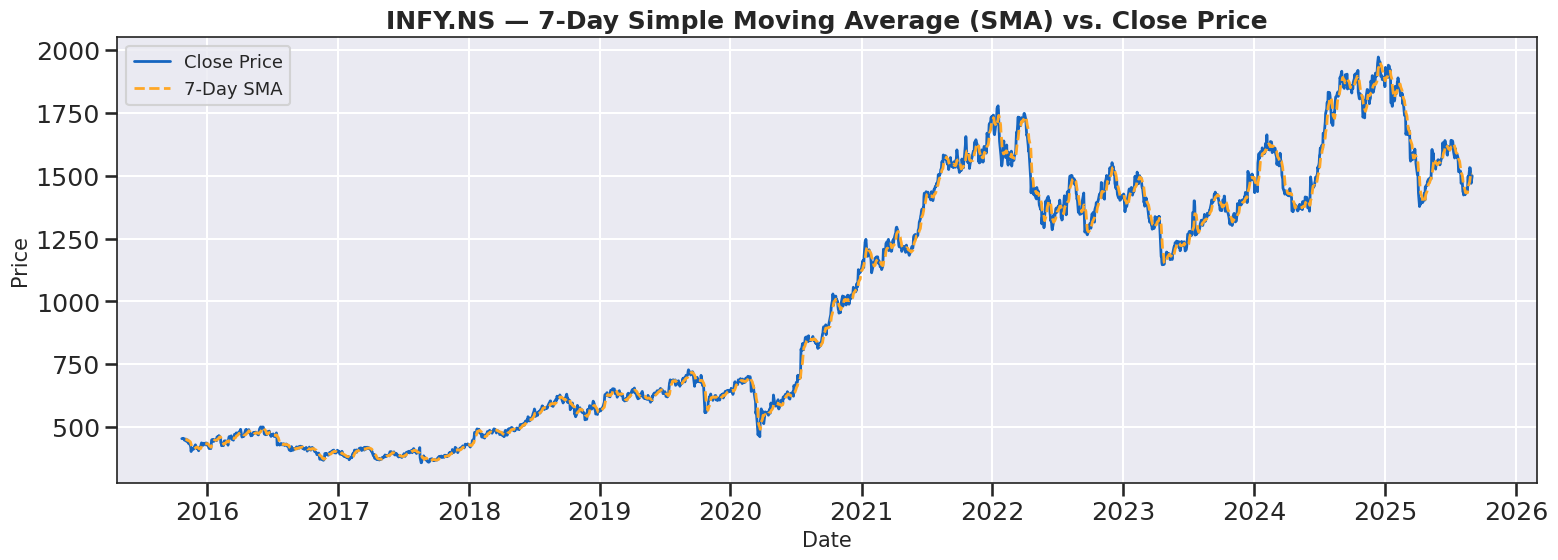

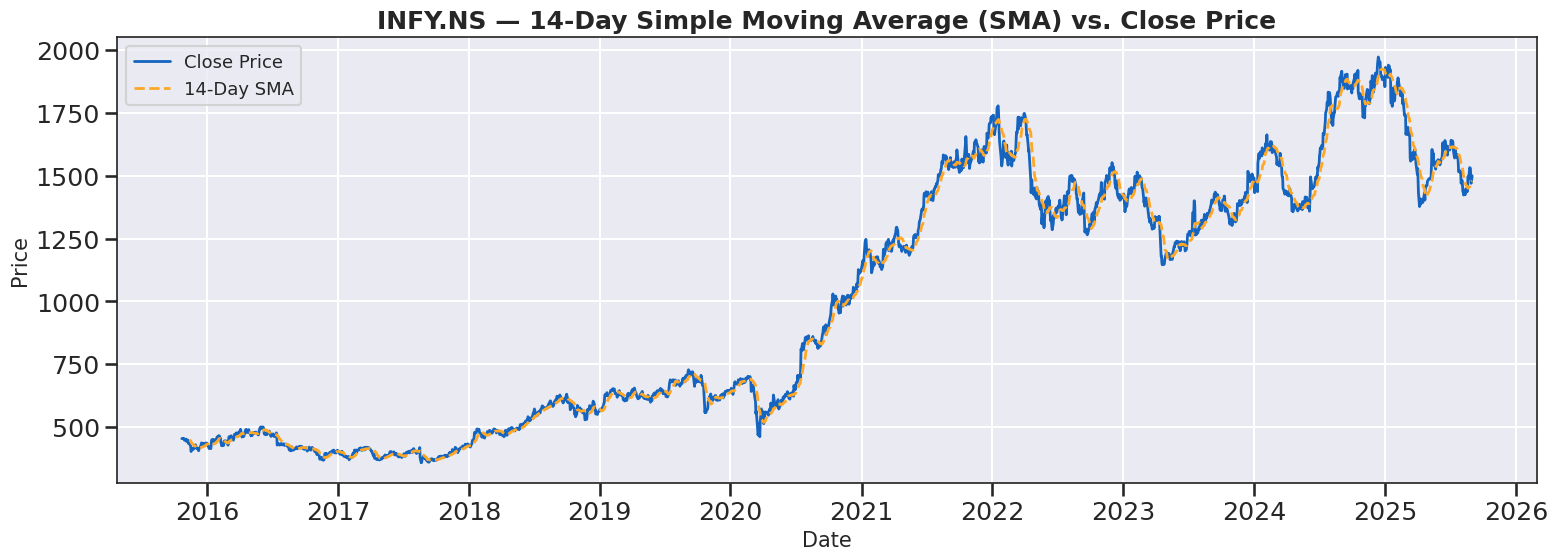

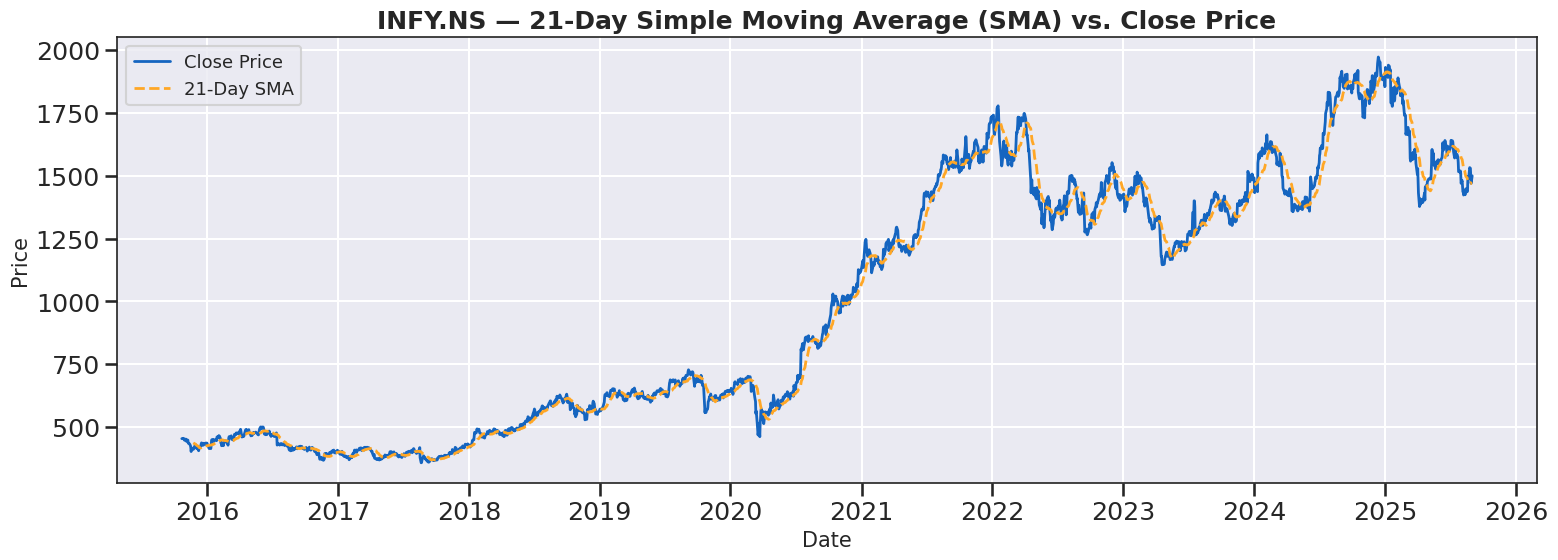

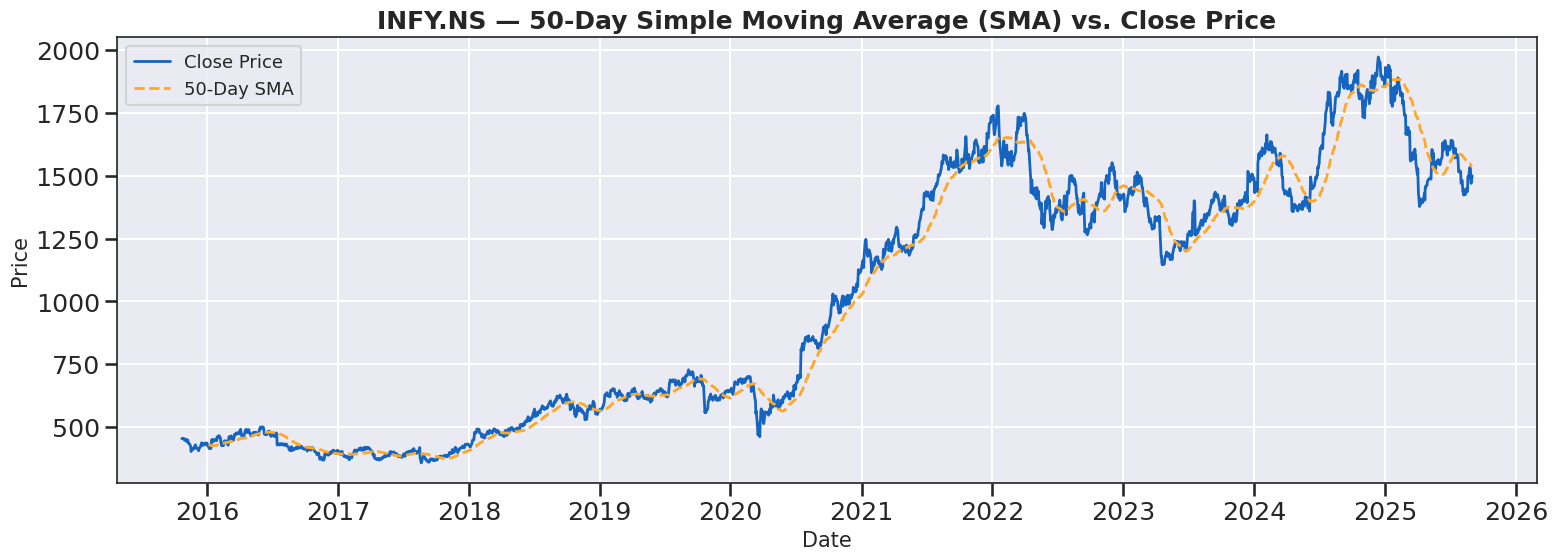

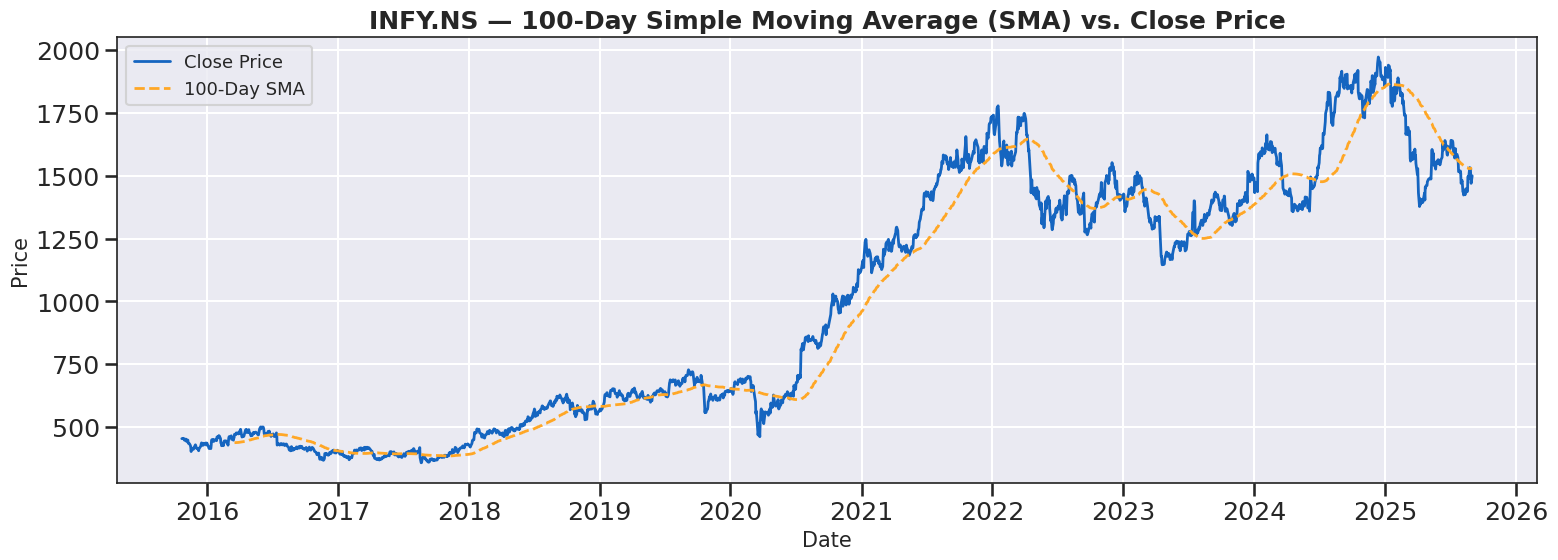

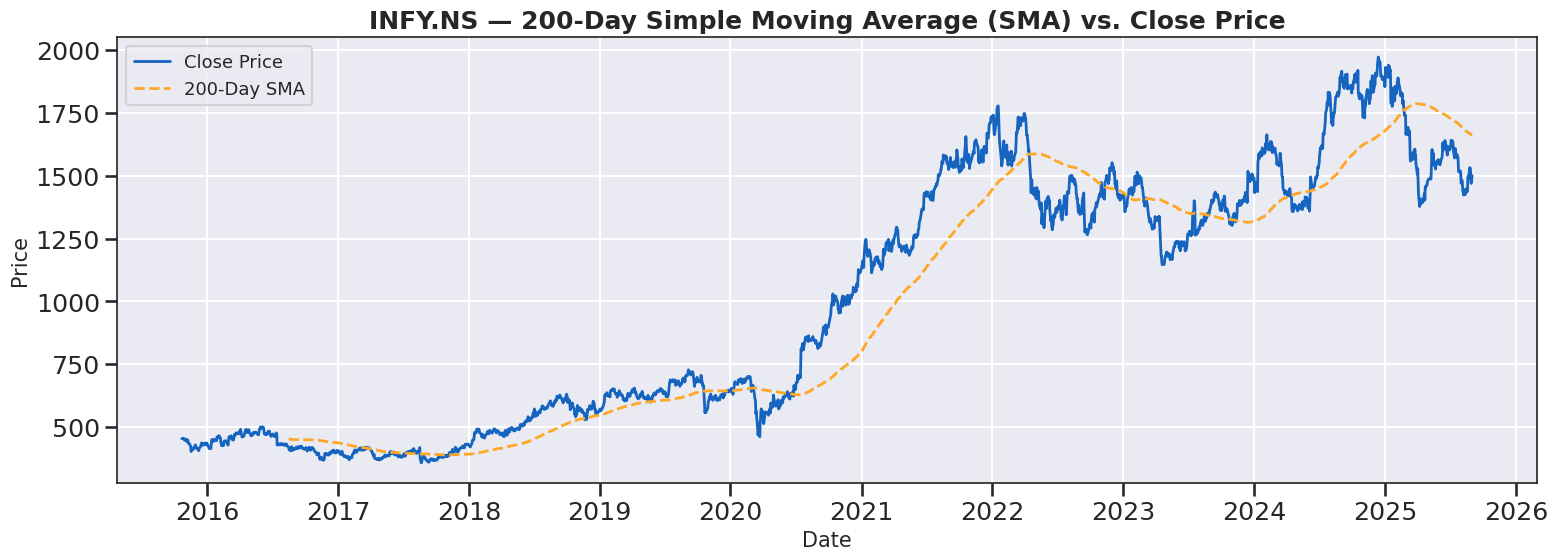

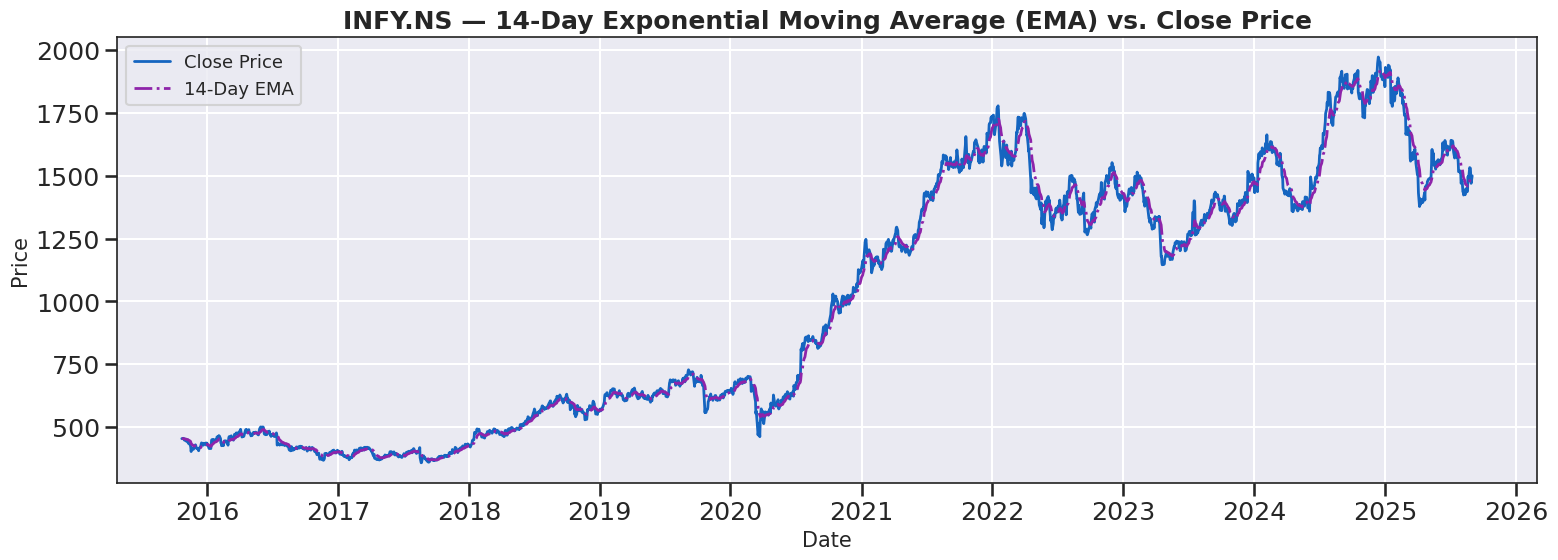

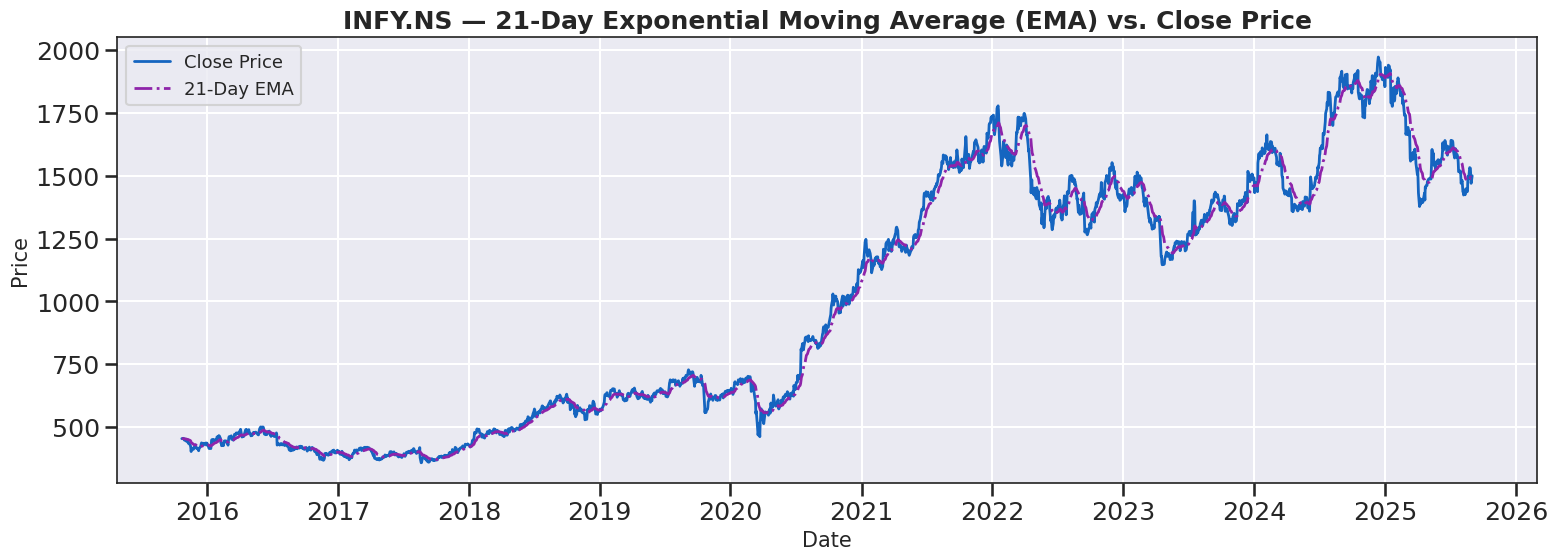

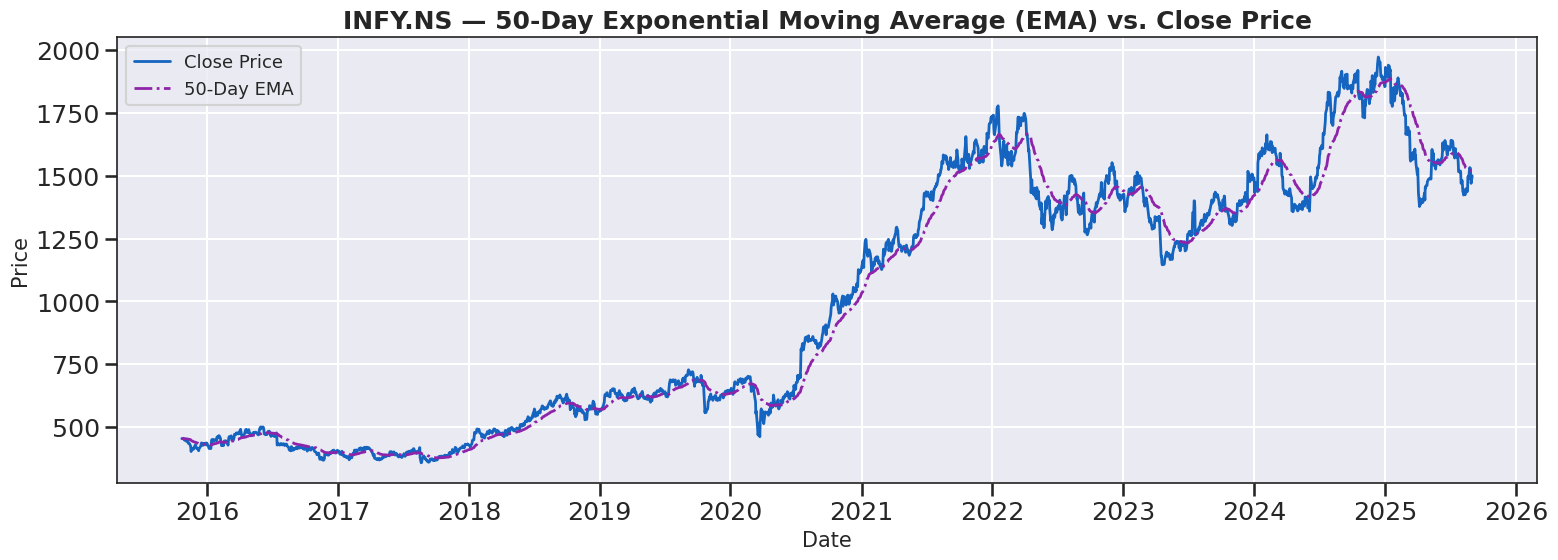

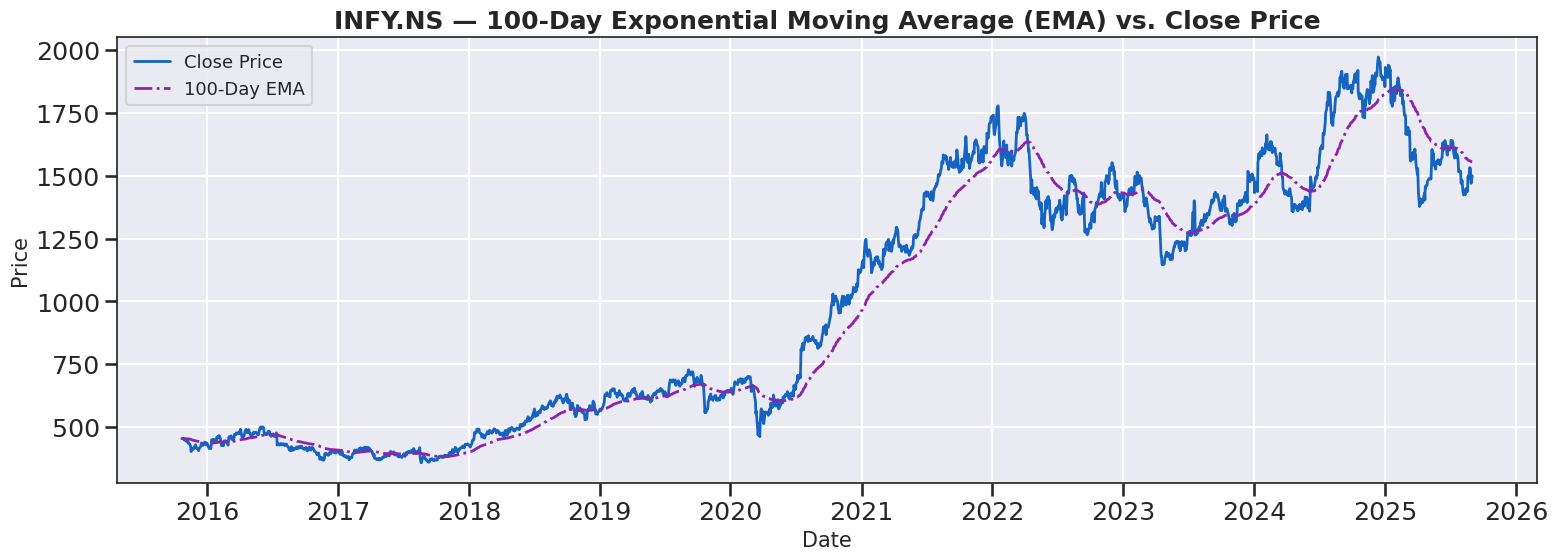

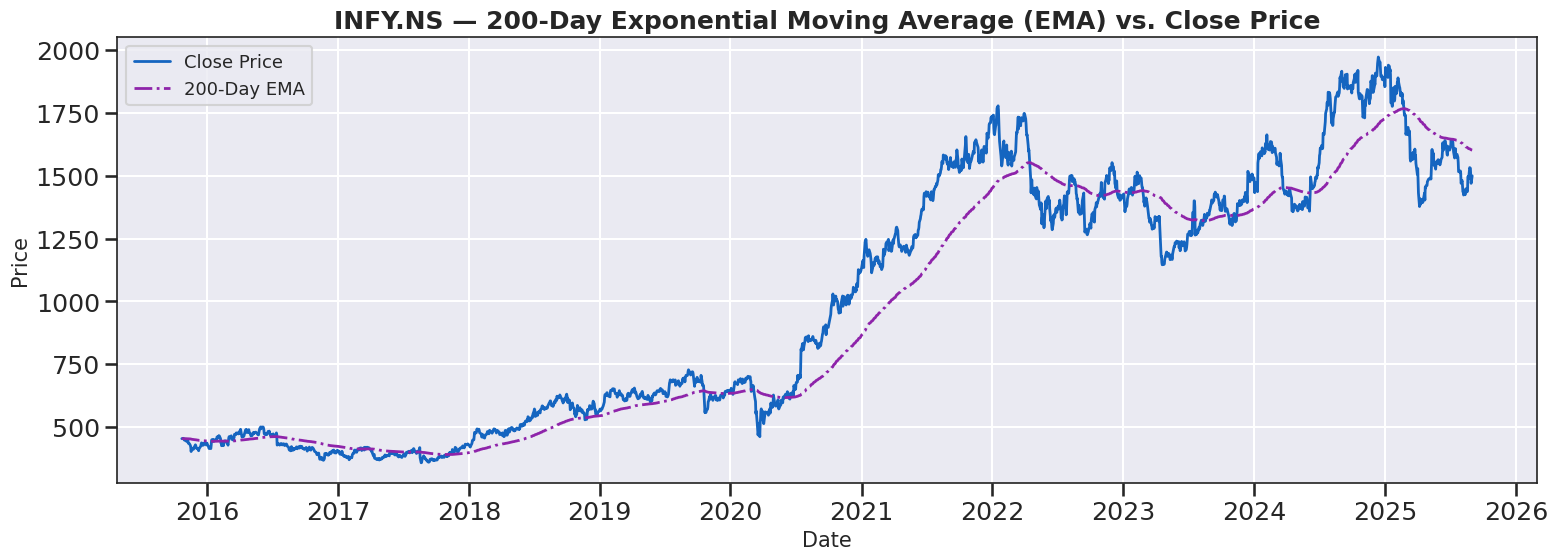

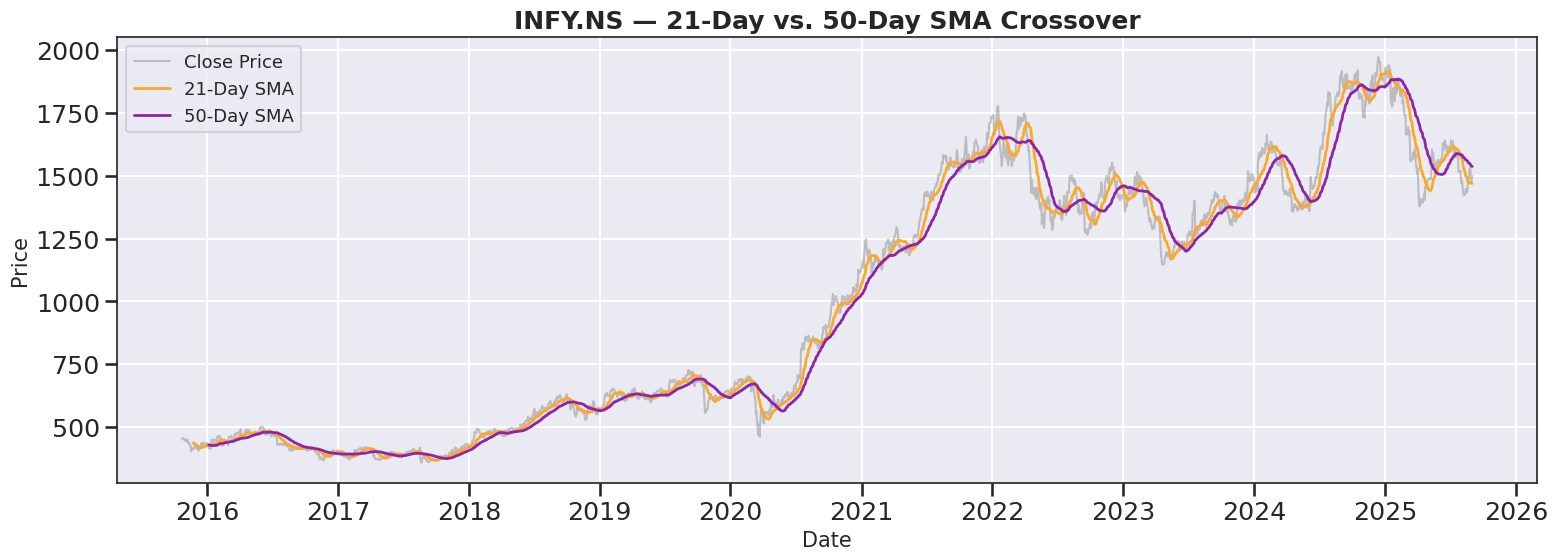

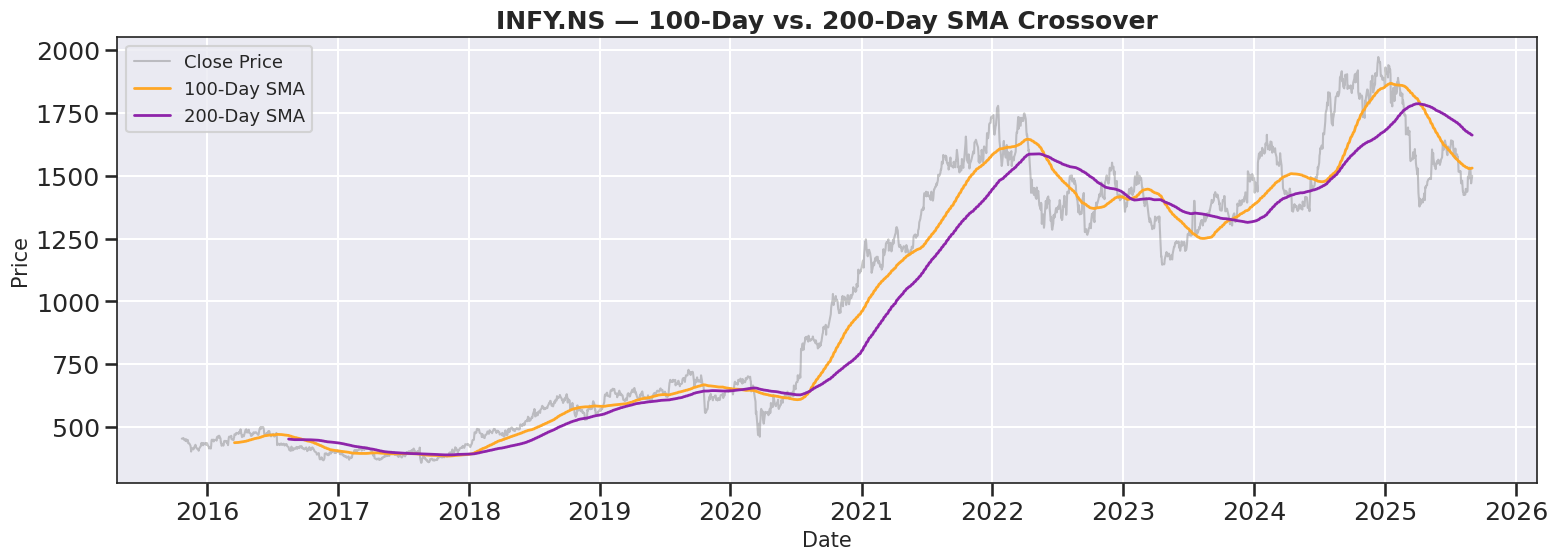

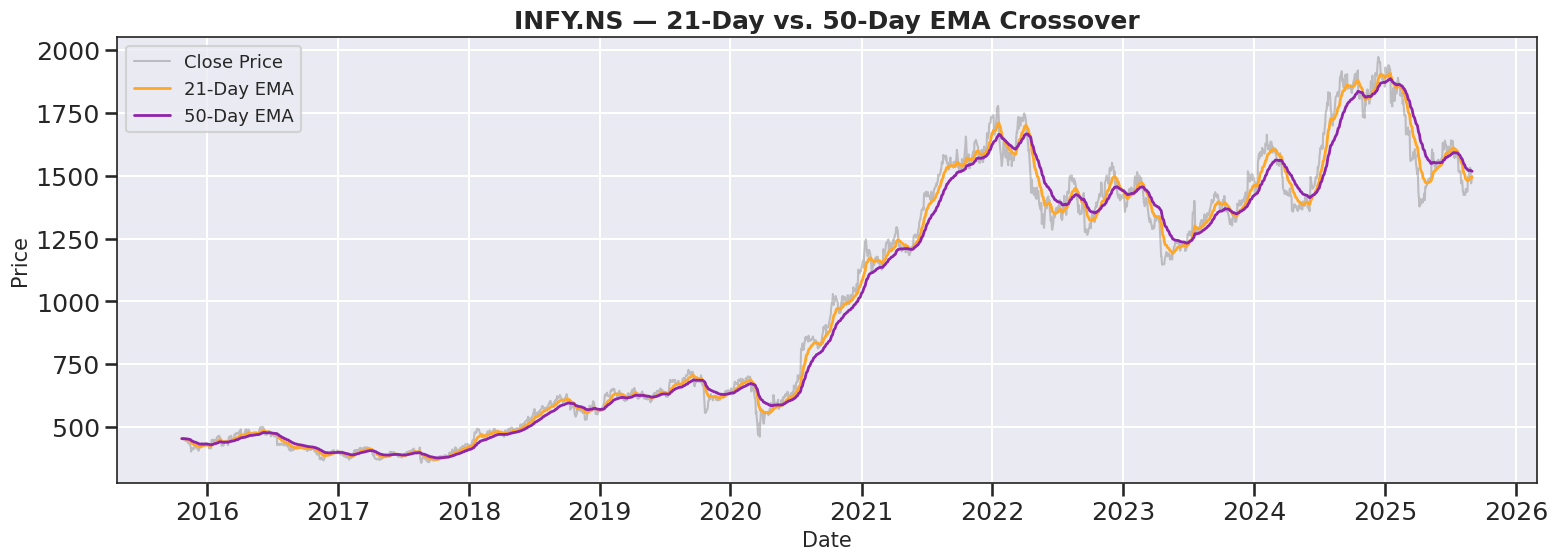

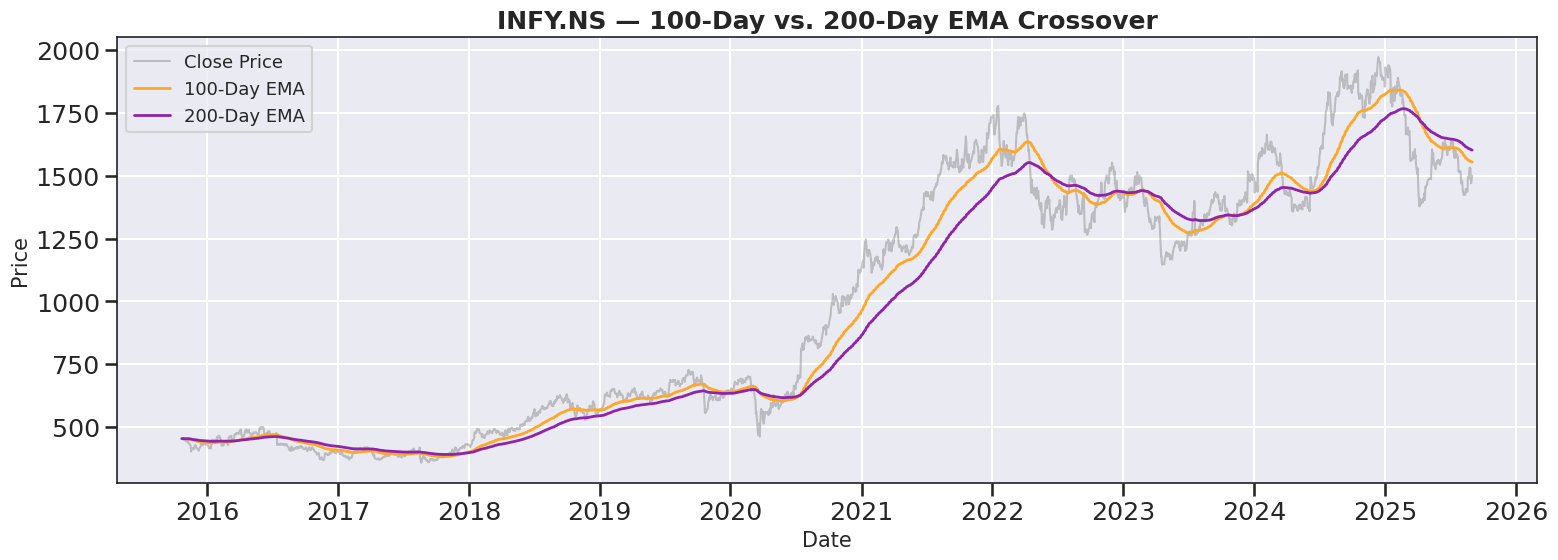

EDA plots generated.

Starting Machine Learning model training...
Training Random Forest...
Random Forest Metrics: MAE=7.77, RMSE=14.97, R2=99.23%
Training XGBoost...
XGBoost Metrics: MAE=12.55, RMSE=21.56, R2=98.40%
Training Gradient Boosting...
Gradient Boosting Metrics: MAE=5.14, RMSE=9.22, R2=99.71%

Model training and evaluation complete.

--- Model Performance Summary ---


,MAE,MSE,RMSE,R-Squared
Random Forest,7.771652,224.229328,14.974289,0.992267
XGBoost,12.551003,464.938324,21.562429,0.983965
Gradient Boosting,5.135932,85.043058,9.221879,0.997067



Forecasting tomorrow's stock price...
Best model selected: Gradient Boosting (R-Squared: 99.71%)
Predicted closing price for tomorrow: 1499.29


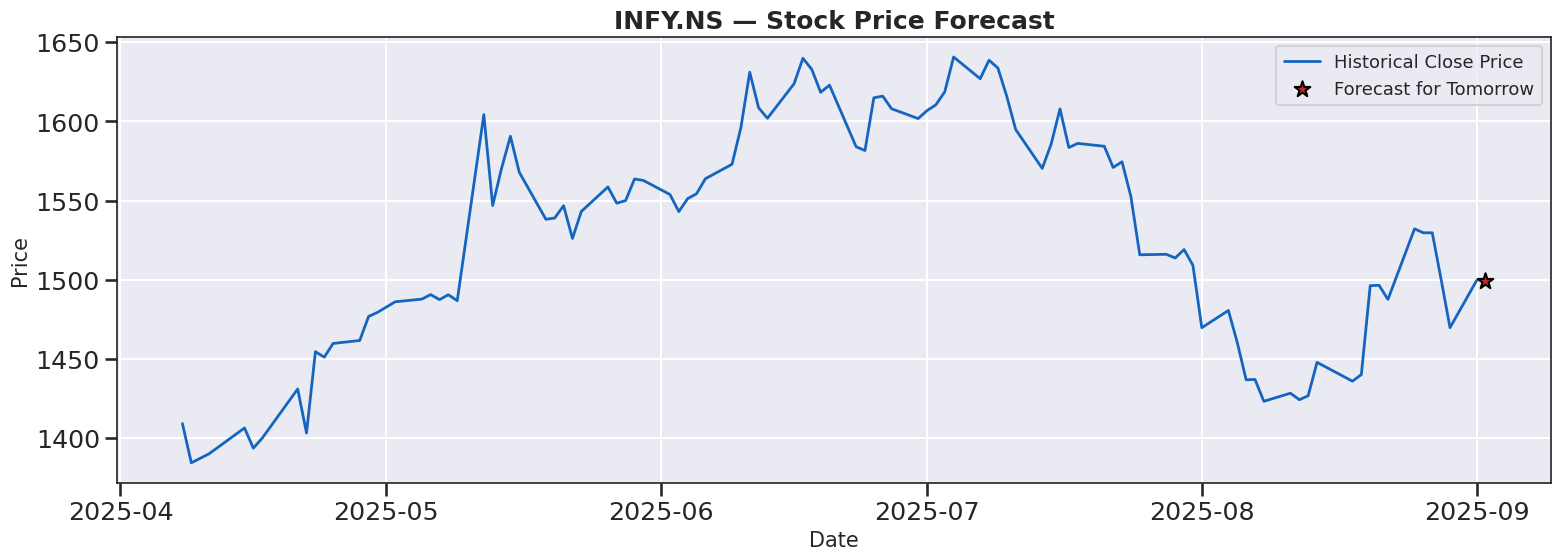


Comparing INFY.NS performance with benchmark ^NSEI...

Data downloaded successfully.


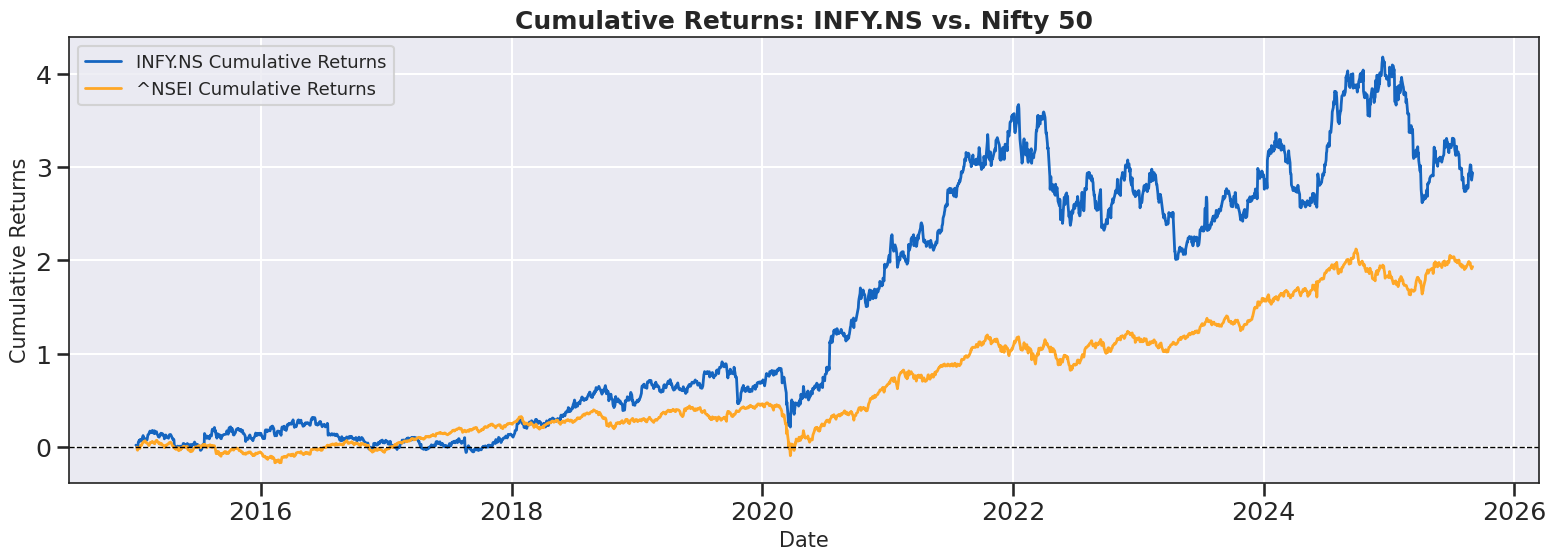


--- Investment Conclusion ---
Over the period from 2015-01-01 to 2025-09-02:
Total Cumulative Return for INFY.NS: 293.92%
Total Cumulative Return for ^NSEI: 193.31%



<div style='background:#e8f5e9;padding:16px;border-radius:10px;'><strong style='font-size:1.4em;color:#2e7d32;'>Recommendation:</strong> <strong>Investing in <span style='color:#1565c0'>INFY.NS</span> would have been </strong><strong style='color:#2e7d32;'>more beneficial</strong><strong> than investing in the <span style='color:#ffa726'>^NSEI</span> index during this period.</strong></div>


--- Analysis Complete ---


In [10]:

# MAIN EXECUTION BLOCK


if __name__ == '__main__':
    # --- User Input ---
    # Colab-friendly input (uncomment below in Colab if desired)
    # stock_ticker = input("Enter the stock ticker symbol (e.g., 'RELIANCE.NS' for NSE or 'GOOGL' for NASDAQ): ").upper()

    # For Colab: Use a default for demonstration, but allow easy modification
    stock_ticker = input("Enter the Stock Ticker : ")  # <-- Change as needed in Colab
    start_date = "2015-01-01"
    end_date = datetime.now().strftime('%Y-%m-%d')
    benchmark_ticker = '^NSEI'  # Nifty 50

    print(f"Analyzing stock: {stock_ticker} (from {start_date} to {end_date})\n")

    # --- Stock Analysis and Forecasting ---
    stock_data = download_stock_data(stock_ticker, start_date, end_date)

    if stock_data is not None:
        stock_data_features = preprocess_and_engineer_features(stock_data.copy())

        # --- EDA ---
        perform_eda(stock_data_features.copy(), stock_ticker)

        # --- ML Modeling ---
        trained_models, metrics = train_and_evaluate_models(stock_data_features)
        print("\n--- Model Performance Summary ---")
        display(metrics.style.background_gradient(cmap='YlGnBu'))

        # --- Forecasting ---
        models_dict = {'models': trained_models, 'metrics': metrics}
        forecast, best_model = forecast_tomorrow(models_dict, stock_data_features.tail(1))
        plot_forecast(stock_data_features, forecast, stock_ticker)

        # --- Benchmark Comparison ---
        compare_with_benchmark(stock_data.copy(), stock_ticker, benchmark_ticker, start_date, end_date)

        print("\n--- Analysis Complete ---")